In [148]:
from numpy import eye, linalg, arange, sqrt, diag, sin, pi, linspace, heaviside, sum as npsum, multiply, conjugate, real, array, zeros
import matplotlib.pyplot as plt

In [149]:
# PARAMETROS DO SISTEMA
h_bar=1 #planck reduzida
m = 0.067 #massa efetiva para GaAs na eq. de Schrödinger
L = 800  # tamanho do sistema
Ry = 26 #eV é a unidade de Energia
a0 = 0.05 #nm é a unidade de distância
h_bar2_m0 = Ry * a0**2
e2 = Ry * a0
k = 13 #constante dielétrica na eq. de Poisson
n2D = 5*10**(-5) #a.u. densidade experimentais

# parametros do poco (GaAs)
xmin_poco = 0.2 * L #a.u. parede do poço
xmax_poco = 0.6 * L #a.u. parede do poço
V_0_poco = 0.01 #a.u. profundidade do poço quadrado

# parametros do tempero
f = 0.1

# parâmetros de convergência
epsilon = 0.002 

# dopagem (0 representa o fundo do poço)
mu = 0 

# DISCRETIZAÇÃO E INTERVALO ABSCISSAS
N=100 #Numero de pontos na rede
dx = L/(N+1)  # discretização> dx = L/N+1 => N = (L/dx) - 1
x = arange(0, N)*dx

# parametros iniciais no ciclo de autoconsistência
chute = zeros(N)
n_3d_loop = diag(arange(N))

In [150]:
# LAPLACIANO DISCRETIZADO
laplaciano = lambda dx,N: -(1 / (dx ** 2)) * (2 * eye(N) - eye(N, k=-1) - eye(N, k=1))
energia_cinetica = -0.5*laplaciano(dx,N)

In [151]:
# DEFINIÇÃO DO POTENCIAL ESTRUTURAL
poco_quadrado_finito = (
    lambda profundidade, xmin, xmax, x: -profundidade
    * heaviside(  # somar profundidade apenas para deixar o fundo do poço = 0
        x - xmin, 1
    )
    * heaviside(xmax - x, 1)
    + profundidade
)   

In [152]:
# POTENCIAIS
# scale = 2
V_poco_quadrado_finito = poco_quadrado_finito(
    profundidade=V_0_poco, xmin=xmin_poco, xmax=xmax_poco, x=x
)
V_hartree = lambda n_3d, k, dx, N: linalg.solve(laplaciano(dx, N), (-4*pi/k)*n_3d)
V_hartree_temperado = lambda tempero, V_1, V_3: f*V_1 + (1-f)*V_3
V_total = lambda V_estrutural, V_interacao: V_estrutural + V_interacao 


In [153]:
# E0_mu (lista de níveis ocupados)
E0_mu = lambda mu, E0_list: npsum(E0_list, where=E0_list<mu)
# Numero de níveis ocupados 
N_levels = lambda mu, E0_list: npsum(E0_list<mu)
# D.O.L 3D
n_3d = lambda phi_list, E0_list, mu, m: npsum(array([(m*(mu-E0_list[j])/(2*pi*h_bar**2))*(conjugate(phi_list[j])*phi_list[j]) for j in range(N_levels(mu, E0_list))]))
# DOL 2D
n_2d_params = lambda mu, m, E0_list: [npsum(E0_list<mu)*m/(2*pi*h_bar**2),-E0_mu(mu, E0_list)] #retorna os coeficientes linear e angular, n_2d_params[0]==a e n_2d_params[1]==b

In [154]:
# O HAMILTONIANO
H = lambda V_efetivo: energia_cinetica + diag(
    V_efetivo
)

In [155]:
V_final = V_total(V_poco_quadrado_finito, V_hartree_temperado(f, chute, V_hartree(n_3d_loop, k, dx, N)))
E0_list, phi_list = linalg.eigh(H(V_final))
n_3d_loop = n_3d(phi_list, E0_list, mu, m)
n_2d_loop = n_2d_params(mu, m, E0_list)
# obtendo energias e estados
# E0, phi_list = linalg.eigh(H)

In [162]:
# funcaozinha para inserir o range do eixo x, autovalores, autovetores e o numero de energias desejado na visualização; possivel inserir potencial para plotar junto
def plotEnPsi_finite_diff(x_values, en, psi, n, scale, *args):
    if args:
        plt.plot(x_values, args[0])
    for j in range(n):
        plt.hlines(
            en[j],
            xmin=x_values[0],
            xmax=x_values[-1],
            colors="C" + str(j),
            linestyles="--",
        )
        plt.plot(x_values, en[j] + scale * psi[:, j],  c="C" + str(j))
    try:
      if args[0]:
          y_min, y_max = (0, scale)
          plt.ylim(y_min, y_max)
    except IndexError:
      pass
    plt.show()

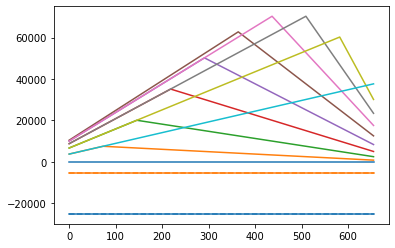

In [164]:
plotEnPsi_finite_diff(x, E0_list, phi_list, 2, 0.001, V_final)